# Shortest Path for Emergency Response

**Project for *Selected Topics for Mathematical Optimization***

Professor Paul Van Liederke

### Contributors:
- Jihwan Lim
- Yunseol Park

# Introduction

In the event of a medical emergency, emergency responders such as ambulances and emergency medical technicians (EMT) are dispatched to the site of such event. During this time, it is the utmost importance that they arrive at the site and take the patient to the nearest hospital as fast as possible so they do not miss the golden hour.

Here, we try to find ways to assign the responder and hospital to optimize the response time. To do so, we simulated a city with pre-existing information taken from Seoul Metropolitan City, South Korea. A simulated city instead of a real one was used to reduce the complexity and time, and also to better visualize the optimization.

### Import libraries

In [1]:
# Import all necessary libraries
import pandas as pd
import random
import math
from math import inf
import haversine
import matplotlib.pyplot as plt
import matplotlib
import datetime
from heapq import heapify, heappop, heappush
from matplotlib.animation import FuncAnimation
from functools import partial

## Data
We generated a simulated city based off of real information from Seoul city, South Korea.

The city of Seoul is divided into smaller regions and the smallest administrative region is called *dong* (동), with each *dong* being around 0.2 to 12 $km^2$. There is 1 administrative office (주민센터) per *dong* and there are 426 of these in Seoul alone.

As mapping an entire city may be computationally challenging, we mapped these offices by their longitude and latitude to make the nodes of our graph. The data of this information was taken from the [Public Data Portal](https://www.data.go.kr/data/15059715/fileData.do).

In [2]:
def filter_data():
    '''
    Filters the data to have administrative office information

    Args:
        None
    Returns:
        loc_dict (dict): dictionary that has the dong name (ㅇㅇ구 ㅇㅇ동) as key 
                         and a tuple with the longitude and latitude as values
    '''
    # Read in data and only keep necessary columns
    city_df = pd.read_csv('data/전국공공시설개방정보표준데이터.csv', 
                          encoding='cp949')
    city_df = city_df[['관리기관명','개방시설명','개방장소명','위도','경도']]
    # Filter on Seoul city
    city_df = city_df[city_df['관리기관명'].str.contains('서울특별시')]
    # Some data are in the column 개방시설명 instead of 개방장소명
    ## Filter on 주민센터 then save the information in the column 개방장소명
    extra_df = city_df[city_df['개방시설명'].str.contains('주민센터')]
    extra_df = extra_df[~extra_df['개방장소명'].str.contains('주민센터')]
    extra_df['개방장소명'] = extra_df['개방시설명'].str.split('주민센터')\
                            .str[0].str.strip()
    extra_df['개방장소명'] = extra_df['개방장소명'].str.split('구 ').str[-1]
    extra_df = extra_df.drop('개방시설명',axis=1).drop_duplicates()
    # The rest of the data are in the column 개방장소명 so drop 개방시설명
    city_df = city_df.drop(['개방시설명'], axis=1)
    city_df = city_df.dropna()      # Remove NA values
    ## Filter on 주민센터
    city_df = city_df[city_df['개방장소명'].str.contains('주민센터')]
    city_df['개방장소명'] = city_df['개방장소명'].str.split('주민센터')\
                           .str[0].str.strip()
    city_df['개방장소명'] = city_df['개방장소명'].str.split('구 ').str[-1]
    # Concatinate the two dataframes together
    loc_df = pd.concat([city_df, extra_df])
    # Change the 관리기관명 column so that only the 구 name is in it
    loc_df['관리기관명'] = loc_df['관리기관명'].str.split().str[1]
    loc_df['관리기관명'] = loc_df['관리기관명'].str.replace('구청','구')
    # Remove duplicates
    loc_df = loc_df.drop_duplicates(subset=['관리기관명', '개방장소명'])
    # Make a new column that contains the columns 관리기관명 and 개방장소명
    loc_df['동'] = loc_df['관리기관명'] + ' ' + loc_df['개방장소명']
    # Convert the dataframe into dictionary with only the columns 동, 위도, 경도
    loc_dict = loc_df.set_index('동')[['경도', '위도']].apply(tuple, axis=1).to_dict()
    return loc_dict
loc_dict = filter_data()
loc_dict

{'노원구 중계4동': (127.077958, 37.658728),
 '노원구 상계1동': (127.054976, 37.679929843),
 '광진구 자양4동': (127.0662584, 37.53409779),
 '광진구 화양동': (127.0713179, 37.54653711),
 '광진구 군자동': (127.075486, 37.555495),
 '도봉구 쌍문2동': (127.0387508, 37.6580211),
 '도봉구 쌍문4동': (127.0283688, 37.6564188),
 '도봉구 쌍문3동': (127.0279086, 37.6489437),
 '도봉구 쌍문1동': (127.0260364, 37.6479992),
 '광진구 광장동': (127.1030098, 37.54688276),
 '광진구 자양1동': (127.0823949, 37.53449795),
 '광진구 자양2동': (127.0843875, 37.52879933),
 '광진구 자양3동': (127.0729024, 37.53383394),
 '광진구 중곡1동': (127.0800521, 37.56066762),
 '광진구 중곡2동': (127.0814751, 37.56015047),
 '광진구 중곡3동': (127.0801381, 37.56880689),
 '광진구 중곡4동': (127.0894329, 37.55909865),
 '광진구 능동': (127.0805521, 37.5537606),
 '광진구 구의1동': (127.0856773, 37.54241324),
 '광진구 구의2동': (127.0899239, 37.54724133),
 '광진구 구의3동': (127.0919847, 37.53799342),
 '도봉구 방학3동': (127.0279921, 37.6591413),
 '도봉구 방학1동': (127.0406367, 37.6641869),
 '도봉구 방학2동': (127.0350425, 37.668177),
 '도봉구 창1동': (127.0440451, 37.6485286

## Simulated city

From the data gathered, we randomly pick 50 as towns or households where the emergency events take place. We also pick some as hospitals or emergency rooms h(ERs). To do so, we make use of the actual ratio between ERs and administrative offices that are in Seoul. Then we also pick some as the emergency responders. Here, we take a third of the number of hospitals. Since the emergency events are set to be always medical in this project, and not other events, we require less responders than there are in reality.

In [3]:
# Get random example
random.seed(100)
keys_list = list(loc_dict.keys())
# List of random names to use for towns
towns = random.sample(keys_list, 50)
keys_list = [i for i in keys_list if i not in towns]
# List of random names to use as hospitals
#ratio = 67/426
ratio = 0.5
hospital = random.sample(keys_list, round(ratio*10))
keys_list = [i for i in keys_list if i not in hospital]
# List of random names to use as ambulance location / emergency services
ambulance = random.sample(keys_list, round(len(hospital)/3))

### Generate graph

From the example from above, we now generate the graphs connecting the nodes. The connections are made randomly, to a random number of nodes between 1 to 3 for the households. For ERs and responders, we make the maximum number of connections to 4 nodes. As for the actual connections, we connect nodes based on the distance (i.e. the closer two nodes are, the more likely they will be connected).

As our data is on longitude and latitude information, we make use of *haversine* distance calculation to calculate the acutal distance in *km*s between the two nodes and set these distances as the edges of the graph. We also change the names of the nodes since their original names are in Korean. The towns or households have the prefix **T**, hospital with **H**, and ambulance or emergency responder with **A**, and the postfix with numbers to them.

In [4]:
def make_paths(loc_dict, towns, hospital, ambulance):
    '''
    Function that connects the chosen nodes together.

    Args:
        loc_dict (dict): dictionary that has the dong name (ㅇㅇ구 ㅇㅇ동) as key 
                         and a tuple with the longitude and latitude as values
        towns (list): list of names of dong 
        hospital (list): list of names of hospitals 
        ambulance (list): list of names of emergency services
    Returns:
        connections (list): list of tuples that contain the haversine distance, 
                            and two names of nodes that are connected together
        graph_dict (dict): subset of 'loc_dict' that only contains the names 
                           given in 'towns' 'hospital' 'ambulance' lists
    '''
    random.seed(50)
    # Make a dictionary with all the nodes with new names and their coordinates
    # Get a list with all the nodes
    city = towns + hospital + ambulance
    graph_dict = {}
    # Number to use as postfix for the name
    town_nodes = 0
    hospital_nodes = 0
    ambulance_nodes = 0
    for node in city:
        # Get lat and lon information of node
        x1, y1 = loc_dict[node]
        # Change name of nodes
        if node in towns:
            town_nodes += 1
            new_node = 'T{}'.format(town_nodes)
        elif node in hospital:
            hospital_nodes += 1
            new_node = 'H{}'.format(hospital_nodes)
        else:
            ambulance_nodes += 1
            new_node = 'A{}'.format(ambulance_nodes)
        graph_dict[new_node] = loc_dict[node]       # Save to graph_dict
    
    # Change the town, hospital, ambulance lists with those with new names
    towns = []
    hospital = []
    ambulance = []
    for key in graph_dict.keys():
        if 'T' in key:
            towns.append(key)
        elif 'H' in key:
            hospital.append(key)
        else:
            ambulance.append(key)

    # Make edges for the graph
    connections = []    # List to save edges
    for node, (x1,y1) in graph_dict.items():
        # List to save distances to all other nodes
        distance = []
        # Get lat and lon information of node
        x1, y1 = graph_dict[node]
        # Choose how many other nodes it is connected to
        if node in towns:
            connect = random.randint(1,3)   # Random if it is a town
        # If it is in 'hospital' or 'ambulance' lists, make the 4 connections
        else:
            connect = 4
        # If the node has already been connected, deduct from 'connect'
        # Only keep the number of connections that needs to be made
        counted = [i[1] for i in connections if node == i[1]]
        connect -= len(counted)
        # Loop over all the nodes to connect with
        for test, (x2,y2) in graph_dict.items():
            # Break loop if no connection is needed
            if connect == 0:    
                break
            # No need to calculate the distance in one node
            if node == test:    
                continue
            # Calculate haversine distance between the two (km)
            dist = haversine.distance((x1,y1),(x2,y2))
            distance.append((test, dist))
        # Sort the distances to the nodes and take the top n nodes (n=connect)
        con_city = sorted(distance, key=lambda x:x[1])[:connect+1]
        connections += [(i[1], node, i[0]) for i in con_city]   # Save the top nodes
    return connections, graph_dict, towns, hospital, ambulance

edges, graph_dict, towns, hospital, ambulance = make_paths(loc_dict, towns, hospital, ambulance)
graph_dict

The graph is then plotted with the emergency responders as red and hospital/ER as blue.

Text(0, 0.5, 'latitude')

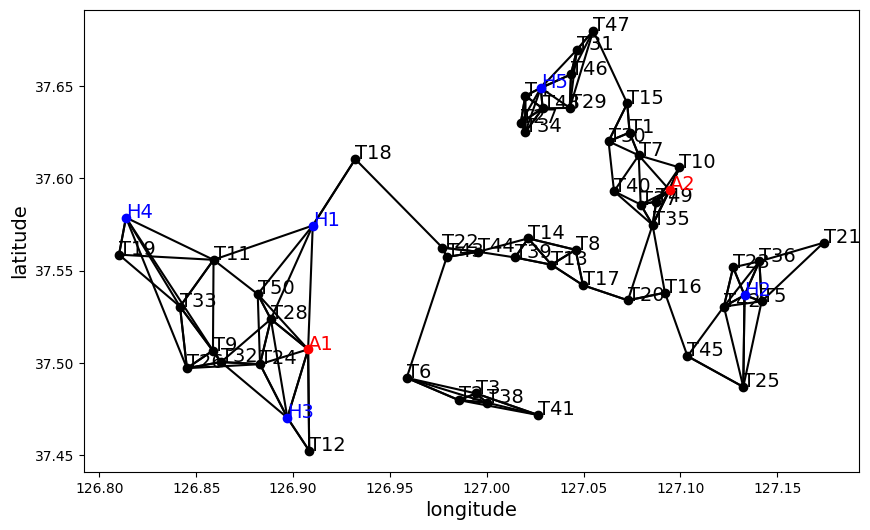

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the nodes
for city, (lon, lat) in graph_dict.items():
    # Use different colors for different types of nodes
    if city in hospital:
        ax.scatter(lon, lat, color="blue", zorder=4)
        ax.text(lon, lat, city, fontsize=14, zorder=5, color="blue")
    elif city in ambulance:
        ax.scatter(lon, lat, color="red", zorder=4)
        ax.text(lon, lat, city, fontsize=14, zorder=5, color="red")
    else:
        ax.scatter(lon, lat, color="black", zorder=3)
        ax.text(lon, lat, city, fontsize=14, zorder=4, color="black")

# Plot the edges
for w, c1, c2 in edges:
    x1, y1 = graph_dict[c1]
    x2, y2 = graph_dict[c2]
    plt.plot([x1,x2],[y1,y2], color='black', zorder=1)

ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)

The distances that we calculated above for the edges are now converted into travel times, and we also add traffic times as well. For the travel time, we assume the ambulance travels at the speed of 70 km/h as the speed limit of the city is usually 50 km/h [\[1\]](). The traffic decreases the speed of travel by 36% [\[2\]](), so that is how the traffic time is calculated.

In [6]:
def edges_to_graph(edges):
    """
    Transforms a set of edges in graphs with adjacenct nodes and travel time 
    and traffic time.
    
    Args:
        edges : a list of edges (tuple of distance and two nodes)
    Returns:
        adj_graph: nested dictionary that has the nodes as the primary keys 
                   and information on their connected nodes and edges as 
                   value. The inner dictionary has the nodes that are connected
                   to the primary keys of the graph as key and the travel 
                   and traffic times in a dictionary as values
    """
    adj_graph = {}  # store in dictionary
    for w, v1, v2 in edges:
        # Ambulances average speed is ~70km/h
        t = math.ceil(w/70*60)  # In minutes
        add_dict = {'TravelTime': round(t,2), 'TrafficTime': round(t/0.36,2)-t}
        if v1 in adj_graph:  # edge already in it
            adj_graph[v1][v2] = add_dict
        else:
            adj_graph[v1] = {v2:add_dict}
        if v2 in adj_graph:  # edge already in it
            adj_graph[v2][v1] = add_dict
        else:
            adj_graph[v2] = {v1:add_dict}
    return adj_graph

adj_graph = edges_to_graph(edges)
adj_graph

{'T1': {'T7': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  'T15': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  'T30': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996}},
 'T7': {'T1': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  'T37': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T30': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T10': {'TravelTime': 3, 'TrafficTime': 5.33},
  'T40': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'A2': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996}},
 'T15': {'T1': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  'T30': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T47': {'TravelTime': 3, 'TrafficTime': 5.33}},
 'T30': {'T1': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T7': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T15': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T40': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996

### Traffic factor

The traffic factors have been generated using real traffic information in Seoul [\[2\]]().

In [7]:
traffic_factor = {'weekday': {}, 'weekend': {}}
for k in range(0,24):
    if k in range(0,7):     # 00:00 to 07:00
        traffic_factor['weekday'][k] = 0.1
        traffic_factor['weekend'][k] = 0.1
    elif k in range(7,9):   # 07:00 to 09:00
        traffic_factor['weekday'][k] = 0.8
        traffic_factor['weekend'][k] = 0.5
    elif k in range(11,13): # 11:00 to 13:00
        traffic_factor['weekday'][k] = 0.5
        traffic_factor['weekend'][k] = 0.5
    elif k in range(17,19): # 17:00 to 19:00
        traffic_factor['weekday'][k] = 0.8
        traffic_factor['weekend'][k] = 0.5
    elif k in range(19,24): # 19:00 to 24:00
        traffic_factor['weekday'][k] = 0.5
        traffic_factor['weekend'][k] = 0.5
    else:                   # All other times
        traffic_factor['weekday'][k] = 0.3
        traffic_factor['weekend'][k] = 0.3

{'weekday': {0: 0.1,
  1: 0.1,
  2: 0.1,
  3: 0.1,
  4: 0.1,
  5: 0.1,
  6: 0.1,
  7: 0.8,
  8: 0.8,
  9: 0.3,
  10: 0.3,
  11: 0.5,
  12: 0.5,
  13: 0.3,
  14: 0.3,
  15: 0.3,
  16: 0.3,
  17: 0.8,
  18: 0.8,
  19: 0.5,
  20: 0.5,
  21: 0.5,
  22: 0.5,
  23: 0.5},
 'weekend': {0: 0.1,
  1: 0.1,
  2: 0.1,
  3: 0.1,
  4: 0.1,
  5: 0.1,
  6: 0.1,
  7: 0.5,
  8: 0.5,
  9: 0.3,
  10: 0.3,
  11: 0.5,
  12: 0.5,
  13: 0.3,
  14: 0.3,
  15: 0.3,
  16: 0.3,
  17: 0.5,
  18: 0.5,
  19: 0.5,
  20: 0.5,
  21: 0.5,
  22: 0.5,
  23: 0.5}}

# Shortest path for emergency responders using Dijkstra algorithm

In [8]:
def reconstruct_path(previous, source, sink):
    """
    Reconstruct the path from the output of the Dijkstra algorithm.

    Inputs:
        previous : a dict with the previous node in the path
        source : the source node
        sink : the sink node
    Ouput:
        the shortest path from source to sink
    """
    if sink not in previous:
        return []
    v = sink
    path = [v]
    while v is not source:
        v = previous[v] 
        path = [v] +path
    return path

In [9]:
def dijkstra(graph, source, sink, start_time, traffic_factor):
    """
    Implementation of Dijkstra's shortest path algorithm.

    Inputs:
        graph : dict representing the weighted graph
        source : the source node
        sink : the sink node
        start_time (datetime): starting time for the path
        traffic_factor (dict): dictionary containing the factors of how the
                               traffic affects traffic time.

    Ouput:
        distance : dict with the distances of the nodes to the source
        previous : dict with for each node the previous node in the
                    shortest path from the source (if one is given)
        N_vertices: number of vertices checked
        time_difference (datetime): difference between the time after path 
                                    and the time before starting path
    """
    # keep tentative distance source to vertex
    # initialize with infinity, except for the source
    distance = {v : inf for v in graph.keys()}
    distance[source] = 0
    # keep previous node in path for backtracking
    previous = {}
    current_time = start_time
    # heap for vertices to check
    # priority based distance from source
    vertices_to_check = [(0, source, current_time)]   # zero indexing !
    N_vertices = 0            # number of visited vertices 

    while vertices_to_check:
        # pop vertex to explore
        # heappop() function removes and returns the smallest element from the heap
        dist, u, current_time = heappop(vertices_to_check)
        N_vertices +=1
        if u == sink:  # sink reached!
            break
        for node, edge in graph[u].items():
            # Travel time
            travel_time = edge['TravelTime']    
            # Traffic time when traffic is in full effect
            traffic_time = edge['TrafficTime']  
            # Add traffic factor to the traffic time
            if current_time.weekday() >= 5:
                current_traffic = traffic_factor['weekend'][current_time.hour] \
                                * traffic_time
            else:
                current_traffic = traffic_factor['weekday'][current_time.hour] \
                                  * traffic_time
            # Get full travel time
            new_time = travel_time + current_traffic
            new_dist = dist + new_time
            # Update the node and the travel time and current time
            if new_dist < distance[node]:
                distance[node] = new_dist
                previous[node] = u
                add_time = current_time + datetime.timedelta(minutes=new_time)
                heappush(vertices_to_check, (new_dist, node, add_time))
                
    if sink is None:
        return distance, previous, N_vertices, current_time - start_time
    else:
        return reconstruct_path(previous, source, sink), distance[sink], \
               N_vertices, current_time - start_time

## Find the shortest path from emergency responder to household

In [10]:
def responder_to_house(algorithm, ambulance, adj_graph, source, day, 
                       traffic_factor, coordinate, silent):
    """
    Function that calculates shortest path from emergency responder to household.

    Args:
        algorithm (function): function to calculate the shortest path 
        ambulance (list): list of emergency responder nodes
        adj_graph (dict): dictionary that contains the graph information with
                          node as key and dictionary containing connections 
                          and travel time as value
        source (string): the node that the emergency event takes place
        day (datetime): the current date and time
        traffic_factor (dict): dictionary that contains the traffic factors
        coordinate (dict): dictionary that contains nodes as keys and their 
                           coordinates as value
        silent (bool): if true, then the information is not printed
    Returns:
        am_to_town (list): list that contains the information of the shortest 
                           path from emergency responder to household
    """
    am_to_town = ['', datetime.timedelta(seconds=86400), 0]
    # Loop over all ambulances
    for start in ambulance:
        # Find shortest path
        if coordinate == None:
            distance, previous, vertices, time_difference = \
                algorithm(adj_graph, start, source, day, traffic_factor)
        else:
            distance, previous, time_difference = \
                algorithm(adj_graph, start, source, graph_dict, day, traffic_factor)

        # Compare time needed to dispatch ambulance from the particular responder
        if am_to_town[1] > time_difference:
            am_to_town = [distance, time_difference, len(distance)]
        # If two responders take the same time, get the one that goes through less nodes
        elif am_to_town[1] == time_difference:
            if am_to_town[2] > len(distance):
                am_to_town = [distance, time_difference, len(distance)]
    if not silent:
        # Print information
        starting_ambulance = am_to_town[0][0]
        print('\tchosen emergency responder: {}'.format(starting_ambulance))
        print('\tshortest path to household: {}'.format(am_to_town[0]))
        print('\ttime needed to household: {} minutes and {} seconds'\
              .format(am_to_town[1].total_seconds()//60, am_to_town[1].total_seconds()%60))
    return am_to_town

## Find the shortest path from household to ER

In [11]:
def house_to_er(algorithm, hospital, adj_graph, source, day, traffic_factor, 
                coordinate, silent):
    """
    Function that calculates shortest path from emergency responder to household.

    Args:
        algorithm (function): function to calculate the shortest path 
        hospital (list): list of hospital nodes
        adj_graph (dict): dictionary that contains the graph information with
                          node as key and dictionary containing connections 
                          and travel time as value
        source (string): the node that the emergency event takes place
        day (datetime): the current date and time
        traffic_factor (dict): dictionary that contains the traffic factors
        coordinate (dict): dictionary that contains nodes as keys and their 
                           coordinates as value
        silent (bool): if true, then the information is not printed
    Returns:
        town_to_hos (list): list that contains the information of the shortest 
                            path from household to hospital
    """
    town_to_hos = ['', datetime.timedelta(seconds=86400), 0]
    # Loop over all hospitals
    for sink in hospital:
        # Find shortest path
        if coordinate == None:
            distance, previous, vertices, time_difference = \
                algorithm(adj_graph, source, sink, day, traffic_factor)
        else:
            distance, previous, time_difference = \
                algorithm(adj_graph, source, sink, graph_dict, day, traffic_factor)
            
        # Compare time needed to go to the particular hospital
        if town_to_hos[1] > time_difference:
            town_to_hos = [distance, time_difference, len(distance)]
        # If two responders take the same time, get the one that goes through less nodes
        elif town_to_hos[1] == time_difference:
            if town_to_hos[2] > len(distance):
                town_to_hos = [distance, time_difference, len(distance)]
    if not silent:
        # Print information
        ending_hospital = town_to_hos[0][-1]
        print('\tchosen hospital: {}'.format(ending_hospital))
        print('\tshortest path to hospital: {}'.format(town_to_hos[0]))
        print('\ttime needed to hospital: {} minutes and {} seconds'\
              .format(town_to_hos[1].total_seconds()//60, town_to_hos[1].total_seconds()%60))
    return town_to_hos

## Generate random example

In [12]:
def find_shortest_path(towns, hospital, ambulance, algorithm, events=20, 
                       start_day = datetime.datetime(2023,6,10,15,00), 
                       day = datetime.datetime(2023,6,10,15,00), 
                       coordinate = None, silent=False):
    """
    Function to find the shortest path from emergency responder to household 
    then to the hospital.

    Args:
        towns (list): list of town nodes
        hospital (list): list of hospital nodes
        ambulance (list): list of emergency responder nodes
        algorithm (function): function for shortest path
        events (int): number of events (default: 20)
        start_day (datetime): starting date and time (default: 2023.06.10 15:00)
        day (datetime): current date and time (default: 2023.06.10 15:00)
        coordinate (dict): dictionary that contains nodes as keys and their
                           coordinates as value
                           (default: None - for dijkstra; required for A* algorithm)
        silent (bool): if true, then the information is not printed (default: False)
    Returns:
        graph_list (list): list that contains information on the shortest path
    """
    graph_list = []
    random.seed(5)
    day_list = sorted(random.sample(range(0,1440),events-1))
    random.seed(14)
    for e in range(events):
        source = random.choice(towns)
        start_time = day
        if not silent:
            print('Event {}: emergency at {} on {}'.format(e+1, source, day))
        am_to_town = responder_to_house(algorithm, ambulance, adj_graph, source, day, traffic_factor, coordinate, silent)
        day += am_to_town[1]
        town_to_hos = house_to_er(algorithm, hospital, adj_graph, source, day, traffic_factor, coordinate, silent)
        day += town_to_hos[1]
        final_sink = town_to_hos[0][-1]
        closest = [i+j for i,j in zip(am_to_town, town_to_hos)]
        graph_list.append([source, final_sink, closest, start_time])
        if not silent:
            print('\tshortest path: {}'.format(closest[0]))
            print('\ttime needed for the shortest path: {} minutes and {} seconds'.format(closest[1].total_seconds()//60, closest[1].total_seconds()%60))
            print('End of event {}: {}'.format(e+1, day))
        if e < events-1:
            day = datetime.timedelta(minutes=day_list[e]) + start_day
    return graph_list

## Animation for dijkstra

First, pool all node and edge information of all events together then animate one event after another in one plot.

In [8]:
def pool_events(graph_list):
    """
    Function that pools all the events into a sequence of nodes to be 
    used for animation.

    Args:
        graph_list (list): list that contains information on the shortest path
    Returns:
        timeline (list): list that contains a sequence of tuples that indicate
                         shortest paths of all events
    """
    timeline = []
    # Loop over each event
    for source, sink, path, start_time in graph_list:
        current_time = start_time
        # The event taking place at current time
        timeline.append((None, current_time, source))
        # Loop over each node in the path
        for i, city in enumerate(path[0]):
            if i+1 < len(path[0]):
                # Node connected to the current one
                end_city = path[0][i+1]     
                # Skip if the two nodes are the same (event node)
                if i > 0 and city == path[0][i+1]:
                    continue
                timeline.append((city, current_time, end_city))
            else:
                # The last node in the path
                timeline.append((city, current_time, None))
                # Added so that the animation can reset before the next event
                timeline.append((None, current_time, None))
                break
            # Get exact travel time to the node
            travel_time = adj_graph[city][end_city]['TravelTime']
            traffic_time = adj_graph[city][end_city]['TrafficTime']
            if current_time.weekday() >= 5:
                current_traffic = traffic_factor['weekend'][current_time.hour] \
                                    * traffic_time
            else:
                current_traffic = traffic_factor['weekday'][current_time.hour] \
                                    * traffic_time
            current_time += datetime.timedelta(minutes=travel_time + current_traffic)
    return timeline

SyntaxError: EOF while scanning triple-quoted string literal (3689381544.py, line 35)

In [14]:
def animating(coordinates, order, eventplace, ax, pointsize, frame):
    """
    Function for animations.

    Args:
        frame (int): frame argument for FuncAnimation function
        coordinates (dict): dictionary with nodes as keys and coordinates as values
        order (list): list containing information on the shortest path
        eventplace (list): list of all nodes where the emergency events take place
        ax (axes): axes object of Matplotlib
        pointsize (int): size of the scatter plots
    Returns:
        None
    """
    # Get current node in frame
    city, time_city, end_city = order[frame]
    # If it is the event node, mark it in green
    if not city and end_city:
        ax.scatter(*coordinates[end_city], color="green", s=pointsize, zorder=2)
        ax.text(coordinates[end_city][0]+0.01, coordinates[end_city][1], end_city, fontsize=10, zorder=5, color="green")
    # Plot nodes
    elif city:
        ax.scatter(*coordinates[city], color="black", s=pointsize, zorder=2)
        if city not in ambulance+hospital+eventplace:
            ax.text(coordinates[city][0]+0.01, coordinates[city][1], city, fontsize=10, zorder=5, color="black")
        # If it is not the ending node (hospital), plot the edges as well
        if end_city:
            xi1, xi2 = coordinates[city]
            xj1, xj2 = coordinates[end_city]
            ax.plot([xi1, xj1], [xi2, xj2], color='black', alpha=0.7, lw=2, zorder=1)
    # Reset the graph for the next event
    else:
        # Loop over all frames until this one and reset the colors and graph if it has been changed before
        for i in range(frame):
            c, t, e = order[i]
            if c:
                lon, lat = coordinates[c]
                # Use different colors for different types of nodes
                if c in hospital:
                    ax.scatter(lon, lat, color="blue", s=pointsize, zorder=2)
                    ax.text(lon+0.01, lat, c, fontsize=10, zorder=5, color="blue")
                elif c in ambulance:
                    ax.scatter(lon, lat, color="red", s=pointsize, zorder=2)
                    ax.text(lon+0.01, lat, c, fontsize=10, zorder=5, color="red")
                else:
                    ax.scatter(lon, lat, color="grey", s=pointsize, zorder=2)
                    ax.text(lon+0.01, lat, c, fontsize=10, zorder=5, color="grey")
                if e:
                    xi1, xi2 = coordinates[c]
                    xj1, xj2 = coordinates[e]
                    ax.plot([xi1, xj1], [xi2, xj2], color='grey', alpha=0.7, lw=2, zorder=1)

def make_shortest_path_animation(coordinates, edges, order, eventplace, fig, ax, pointsize=100):
    """
    Function to plot the graph and animation for all events.

    Args:
        coordinates (dict): dictionary with nodes as keys and coordinates as values
        edges (list): edge information
        order (list): list containing information on the shortest path
        eventplace (list): list of all nodes where the emergency events take place
        fig (figure): Matplotlib figure object
        ax (axes): axes object of Matplotlib
        pointsize (int): size of the scatter plots (default: 100)
    Returns:
        None
    """
    # Plot edges
    for w, i, j in edges:
        xi1, xi2 = coordinates[i]
        xj1, xj2 = coordinates[j]
        ax.plot([xi1, xj1], [xi2, xj2], color='grey', alpha=0.7, lw=2, zorder=1)

    # Plot nodes
    for city, (lon, lat) in coordinates.items():
        # Use different colors for different types of nodes
        if city in hospital:
            ax.scatter(lon, lat, color="blue", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="blue")
        elif city in ambulance:
            ax.scatter(lon, lat, color="red", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="red")
        else:
            ax.scatter(lon, lat, color="grey", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="grey")
    
    # Plot animations
    anim = FuncAnimation(fig, partial(animating, coordinates, order, eventplace, ax, pointsize),
                                frames=range(len(order)), interval=500)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return anim

# Shortest path for emergency responders using Dijkstra algorithm

In [ ]:
# Heuristic distance function using haversine distance and traffic factor
def heuristic_distance(a, b, coordinates, current_time, traffic_factor):
    x1, y1, x2, y2 = coordinates[a][1], coordinates[a][0], coordinates[b][1], coordinates[b][0]
    dist = haversine.distance((x1,y1),(x2,y2))
    travel_time = math.ceil(dist/70*60)  # In minutes
    traffic_time =  round(travel_time/0.36,2)-travel_time
    if current_time.weekday() >= 5:
        current_traffic = traffic_factor['weekend'][current_time.hour] * traffic_time
    else:
        current_traffic = traffic_factor['weekday'][current_time.hour] * traffic_time
    new_time = travel_time + current_traffic
    return new_time

In [17]:
def astar_search(graph, source, sink, coordinates, start_time, traffic_factor):
    # Initialize distances to inf, and set distance to source to 0
    distance = {v: inf for v in graph.keys()}
    distance[source] = 0

    # Empty dictionary to store previous vertices in the path
    previous = {}

    # Initialize current_time with start_time and create priority queue for vertices
    current_time = start_time
    vertices_to_check = [(heuristic_distance(source, sink, coordinates,current_time, traffic_factor), source, current_time)]

    while vertices_to_check:
        # Get the vertex with the minimum estimated total cost (heuristic distance)
        heurisitc_dist, u, current_time = heappop(vertices_to_check)

        # Break out of the loop if the current vertex is the sink
        if u == sink:
            break

        # Update distances and add neighbors to priority queue
        for neighbor, neighbor_dist in graph[u].items():
            travel_time = neighbor_dist['TravelTime']
            traffic_time = neighbor_dist['TrafficTime']
            if current_time.weekday() >= 5:
                current_traffic = traffic_factor['weekend'][current_time.hour] * traffic_time
            else:
                current_traffic = traffic_factor['weekday'][current_time.hour] * traffic_time
            new_time = travel_time + current_traffic
            new_dist = distance[u] + new_time

            if new_dist < distance[neighbor]:
                distance[neighbor] = new_dist
                previous[neighbor] = u

                # Update the time and push the neighbor onto the priority queue
                add_time = current_time + datetime.timedelta(minutes=new_time)
                f_value = new_dist + heuristic_distance(neighbor, sink, coordinates,current_time, traffic_factor)
                heappush(vertices_to_check, (f_value, neighbor, add_time))
                
    # Reconstruct the path and return it with the distance and total time
    if not previous:
        return None, inf
    path = reconstruct_path(previous, source, sink)
    return path, distance[sink], current_time - start_time


# Comparison between Dijkstra and a\* algorithm

## Path for Dijkstra and A\* algorithm

In [18]:
events = 20

graph_list_dijkstra = find_shortest_path(towns, hospital, ambulance, dijkstra, events)

Event 1: emergency at T7 on 2023-06-10 15:00:00
	chosen emergency responder: A2
	shortest path to household: ['A2', 'T7']
	time needed to household: 3.0 minutes and 4.0800000000000125 seconds
	chosen hospital: H5
	shortest path to hospital: ['T7', 'T1', 'T15', 'T47', 'T31', 'H5']
	time needed to hospital: 13.0 minutes and 48.0 seconds
	shortest path: ['A2', 'T7', 'T7', 'T1', 'T15', 'T47', 'T31', 'H5']
	time needed for the shortest path: 16.0 minutes and 52.08000000000004 seconds
End of event 1: 2023-06-10 15:16:52.080000
Event 2: emergency at T40 on 2023-06-10 15:59:00
	chosen emergency responder: A2
	shortest path to household: ['A2', 'T37', 'T40']
	time needed to household: 6.0 minutes and 8.160000000000025 seconds
	chosen hospital: H5
	shortest path to hospital: ['T40', 'T30', 'T15', 'T47', 'T31', 'H5']
	time needed to hospital: 16.0 minutes and 52.08000000000004 seconds
	shortest path: ['A2', 'T37', 'T40', 'T40', 'T30', 'T15', 'T47', 'T31', 'H5']
	time needed for the shortest path:

In [19]:
graph_list_astar = find_shortest_path(towns, hospital, ambulance, astar_search, events, coordinate=graph_dict)

Event 1: emergency at T7 on 2023-06-10 15:00:00
	chosen emergency responder: A2
	shortest path to household: ['A2', 'T7']
	time needed to household: 3.0 minutes and 4.0800000000000125 seconds
	chosen hospital: H5
	shortest path to hospital: ['T7', 'T1', 'T15', 'T47', 'T31', 'H5']
	time needed to hospital: 13.0 minutes and 48.0 seconds
	shortest path: ['A2', 'T7', 'T7', 'T1', 'T15', 'T47', 'T31', 'H5']
	time needed for the shortest path: 16.0 minutes and 52.08000000000004 seconds
End of event 1: 2023-06-10 15:16:52.080000
Event 2: emergency at T40 on 2023-06-10 15:59:00
	chosen emergency responder: A2
	shortest path to household: ['A2', 'T37', 'T40']
	time needed to household: 6.0 minutes and 8.160000000000025 seconds
	chosen hospital: H5
	shortest path to hospital: ['T40', 'T30', 'T15', 'T47', 'T31', 'H5']
	time needed to hospital: 16.0 minutes and 52.08000000000004 seconds
	shortest path: ['A2', 'T37', 'T40', 'T40', 'T30', 'T15', 'T47', 'T31', 'H5']
	time needed for the shortest path:

In [20]:
timeline_dijkstra = pool_events(graph_list_dijkstra)
timeline_astar = pool_events(graph_list_astar)

## Path Animation for Dijkstra and A* algorithm

<img src="animations/Dijkstra_animated_full.gif" alt="Drawing" class="" width="750px">
<img src="animations/Astar_animated_full.gif" alt="Drawing" class="" width="750px">

## Time comparison between Dijkstra and A\* algorithm

In [81]:
%timeit find_shortest_path(towns, hospital, ambulance, dijkstra, events, silent=True)

16.6 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
%timeit find_shortest_path(towns, hospital, ambulance, astar_search, events, coordinate=graph_dict, silent=True)

32.7 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
day = datetime.datetime(2023,6,10,15,0)
%timeit dijkstra(adj_graph, 'A2', 'T7', day, traffic_factor)
day = datetime.datetime(2023,6,10,15,3,4)
%timeit dijkstra(adj_graph, 'A2', 'H5', day, traffic_factor)
# 57.1 µs

12.6 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
44.5 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
day = datetime.datetime(2023,6,10,15,0)
%timeit astar_search(adj_graph, 'A2', 'T7', graph_dict, day, traffic_factor)
day = datetime.datetime(2023,6,10,15,3,4)
%timeit astar_search(adj_graph, 'A2', 'H5', graph_dict, day, traffic_factor)
# 57.9 µs

13.9 µs ± 61.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
44 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
day = datetime.datetime(2023,6,10,15,0)
%timeit dijkstra(adj_graph, 'A2', 'T45', day, traffic_factor)
day = datetime.datetime(2023,6,10,15,6)
%timeit dijkstra(adj_graph, 'T45', 'H2', day, traffic_factor)
# 39.6 µs

27.2 µs ± 372 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
12.4 µs ± 903 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
day = datetime.datetime(2023,6,10,15,0)
%timeit astar_search(adj_graph, 'A2', 'T40', graph_dict, day, traffic_factor)
day = datetime.datetime(2023,6,10,15,6)
%timeit astar_search(adj_graph, 'T40', 'H5', graph_dict, day, traffic_factor)
# 62 µs

19 µs ± 185 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
43 µs ± 582 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
day = datetime.datetime(2023,6,10,15,0)
%timeit dijkstra(adj_graph, 'A2', 'T45', day, traffic_factor)
day = datetime.datetime(2023,6,10,15,15)
%timeit dijkstra(adj_graph, 'T40', 'H2', day, traffic_factor)
# 83.3 µs

27.2 µs ± 257 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
56.1 µs ± 591 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
day = datetime.datetime(2023,6,10,15,0)
%timeit astar_search(adj_graph, 'A2', 'T45', graph_dict, day, traffic_factor)
day = datetime.datetime(2023,6,10,15,15)
%timeit astar_search(adj_graph, 'T45', 'H2', graph_dict, day, traffic_factor)
# 43.4 µs

23.8 µs ± 39.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
19.6 µs ± 886 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Discussion

Theoritocally, A\* algorithm takes smamller time than dijksta method if optimal heuristic distance mehtod is chosen. In our case dijkstra method took less time to caculate shortest distance.\
It means that our chosen heurisitc distance method, haversine method, might not be optimal for this case.

This may be because:
1. Different from Cartesian coordinate problem
2. Time factor
3. Traffic factor

We compared runtime of each event case by case and the taken time varied from case to case.\
It means that comparison of runtime of both methods is not significant.

# References

1. Pappinen, J., & Nordquist, H. (2022). Driving Speeds in Urgent and Non-Urgent Ambulance Missions during Normal and Reduced Winter Speed Limit Periods-A Descriptive Study. Nursing reports (Pavia, Italy), 12(1), 50–58. https://doi.org/10.3390/nursrep12010006
2. Seoul Metropolitan City (2022). 2022 Report of Traffic Speeds in Seoul Metropolitan City. 51-6110000-002492-10 (https://topis.seoul.go.kr/refRoom/openRefRoom_1.do)